# Gaussian Process

In [30]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.kernel_ridge import KernelRidge as KR

In [128]:
import warnings
warnings.simplefilter('ignore')

## Process the Datasetes

In [28]:
import pandas as pd
import git

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
datadir = f"{homedir}/data/us/"

df = pd.read_csv(datadir + 'covid/nyt_us_counties.csv')

In [29]:
df['date_processed'] = pd.to_datetime(df['date'].values)
df['date_processed'] = (df['date_processed'] - df['date_processed'].min()) / np.timedelta64(1, 'D')

In [31]:
df.head()

,date,county,state,fips,cases,deaths,date_processed
0,2020-01-21,Snohomish,Washington,53061.0,1,0,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0,1.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0,2.0
3,2020-01-24,Cook,Illinois,17031.0,1,0,3.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0,3.0


Fix the missing FIPS codes for some counties

In [32]:
# Manually set the FIPS codes for NYC and Guam as the data does 
# not have those set. 
df.loc[df['county'] == 'New York City', 'fips'] = 25017
df.loc[df['state'] == 'Guam', 'fips'] = 66010

# Remove areas with no FIPS codes.
df = df[df['fips'].isna() == False]

Great! Let's also make a helper function to select data from a region, starting when the pandemic hit to be able to fit models.

In [33]:
# return data ever since first min_cases cases
def select_region(df, fips, min_deaths=-1):
    d = df.loc[df['fips'] == fips]
    deaths = np.where(d['deaths'].values > min_deaths)[0]
    if len(deaths) == 0:
        return []
    start = deaths[0]
    d = d[start:]
    return d

In [161]:
import utils2 as utils
df = utils.get_processed_df()
print(df.head)

<bound method NDFrame.head of               date      county       state     fips  cases  deaths  \
0       2020-01-21   Snohomish  Washington  53061.0      1       0   
1       2020-01-22   Snohomish  Washington  53061.0      1       0   
2       2020-01-23   Snohomish  Washington  53061.0      1       0   
3       2020-01-24        Cook    Illinois  17031.0      1       0   
4       2020-01-24   Snohomish  Washington  53061.0      1       0   
...            ...         ...         ...      ...    ...     ...   
121038  2020-05-06    Sublette     Wyoming  56035.0      3       0   
121039  2020-05-06  Sweetwater     Wyoming  56037.0     19       0   
121040  2020-05-06       Teton     Wyoming  56039.0     98       1   
121041  2020-05-06       Uinta     Wyoming  56041.0      8       0   
121042  2020-05-06    Washakie     Wyoming  56043.0      7       0   

        date_processed  
0                  0.0  
1                  1.0  
2                  2.0  
3                  3.0  
4   

In [35]:
import pymc3 as pm
import arviz as az

## Gaussian Process with Erf prior

In [36]:
import erf_model_small_changes as em

In [164]:
out_fips, all_row_starts = utils.all_output_fips('sample_submission.csv')
print(len(out_fips))

3223


In [165]:
county_fips = 13125
d = select_region(df, county_fips)
print(d == [])
if np.max(d['deaths']) == 0:
    result = np.zeroes((num_days, 9))
print(d.tail)

True


TypeError: list indices must be integers or slices, not str

In [159]:
import theano.tensor as tt

class Erf(pm.gp.mean.Mean):
    def __init__(self, fit_func, params):
        # Erf.__init__(self)
        self.fit_func = fit_func
        self.params = params

    def __call__(self, X):
        X = X.reshape(1, -1)[0]
        return em.run_model(self.fit_func, self.params, X)

In [140]:

with pm.Model() as gp_covid_model:
    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)

    fit_func, popt, pcov, X_train, y_train, X_pred = em.fit_erf(df, county_fips)
    print(popt)
    print(y_train)
#     errors = np.sqrt(np.diag(pcov))
#     print(errors)
    # X_pred = X_pred[X_pred >= X_train[0]]

    # Set the Erf prior
    M = Erf(fit_func, popt)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ)

    σ = pm.HalfNormal('σ', 50)

    covid_deaths_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    covid_deaths_gp.marginal_likelihood('covid_deaths', X=X_train.reshape(-1, 1), 
                           y=y_train, noise=σ)

[4.27859357e+00 4.24675064e-02 9.06976142e+01]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     1     5     7    10    20    22    43    60    99   131   192
   280   365   450   672   776   914  1096  1374  1562  1867  2254  2472
  3485  4009  4571  5150  5663  6202  6717  7154  7690  8215  8632  8632
  8632  9708 10009 10301 10614 10889 11157 11419 11648 11857 12067 12325
 12514 12700 12895 13064 13207 13336 18993]


In [141]:
# tune = 2000, random_seed=42
if len(popt) == 2:
    with gp_covid_model:
        gp_trace = pm.sample(100, tune=100, cores=2, random_seed=10)
else:
    with gp_covid_model:
        gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains, 10 divergences: 100%|██████████| 6000/6000 [00:42<00:00, 139.66draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


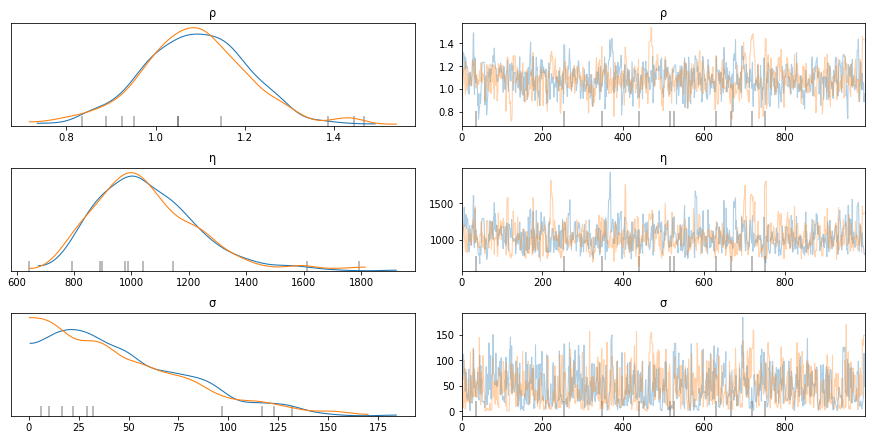

In [142]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [143]:
with gp_covid_model:
    covid_pred = covid_deaths_gp.conditional("covid_pred", X_pred.reshape(-1, 1))
    gp_covid_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred], samples=3, random_seed=42)

100%|██████████| 3/3 [00:00<00:00,  5.70it/s]


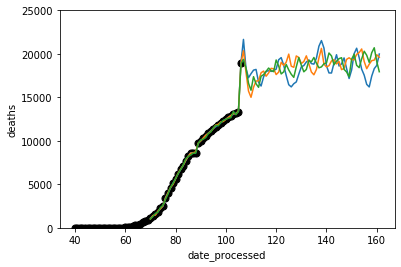

In [151]:
ax = d.plot.scatter(x='date_processed', y='deaths', c='k', s=50)
ax.set_ylim(0, 25000)
for x in gp_covid_samples['covid_pred']:
    ax.plot(X_pred, x)

In [152]:
with gp_covid_model:
    gp_covid_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred], samples=100, random_seed=42)

100%|██████████| 100/100 [00:01<00:00, 95.05it/s]


(0, 25000)

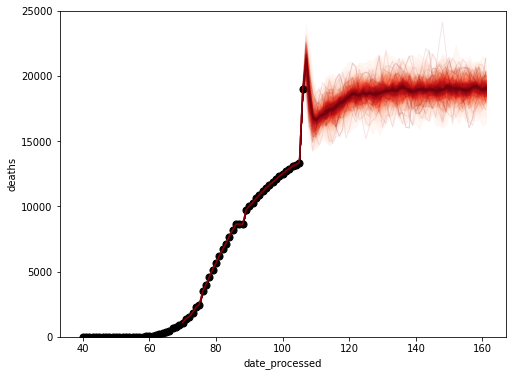

In [154]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_covid_samples['covid_pred'], X_pred)
d.plot.scatter(x='date_processed', y='deaths', c='k', s=50, ax=ax)
ax.set_ylim(0, 25000)

In [155]:
with gp_covid_model:
    covid_pred_noise = covid_deaths_gp.conditional("covid_pred_noise", X_pred.reshape(-1,1), pred_noise=True)
    gp_covid_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred_noise], samples=500, random_seed=42)

100%|██████████| 500/500 [00:04<00:00, 109.40it/s]


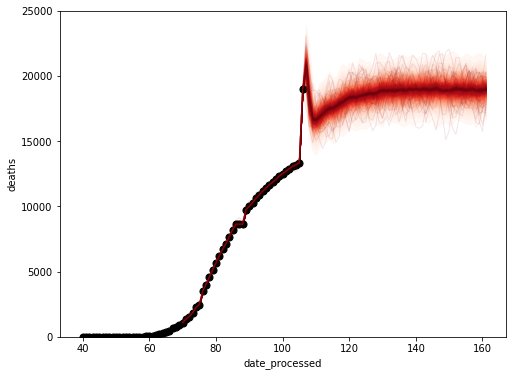

In [157]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_covid_samples['covid_pred_noise'], X_pred)
d.plot.scatter(x='date_processed', y='deaths', c='k', s=50, ax=ax)
ax.set_ylim(0, 25000);

In [138]:
print(np.diff(gp_covid_samples['covid_pred_noise'][1]))
print(np.diff(gp_covid_samples['covid_pred_noise'])[1])
# print(np.percentile(gp_covid_samples['covid_pred_noise'], 90, axis=0))

[-3.52529377e-04 -2.68350934e-04 -1.84324740e-04 -9.96145921e-05
 -1.46637970e-05  7.02570277e-05  1.53586641e-04  2.37415554e-04
  3.23514787e-04  4.06412059e-04  4.91127403e-04  5.76567681e-04
  6.58640106e-04  7.43706912e-04  8.28061384e-04  9.11526646e-04
  9.96120423e-04  1.07945731e-03  1.16280947e-03  1.24756242e-03
  1.33072042e-03  1.41333885e-03  1.49797216e-03  1.58275088e-03
  1.66506764e-03  1.74894235e-03  1.83133225e-03  1.91530962e-03
  1.99810662e-03  2.08076134e-03  2.16433425e-03  2.24880516e-03
  2.33090819e-03  2.41391797e-03  2.49610959e-03  2.57922688e-03
  2.66248948e-03  2.74502697e-03  2.82754606e-03  2.90970468e-03
  2.99265029e-03  3.07393069e-03  3.15721105e-03  3.23981347e-03
  3.32196645e-03  3.40418882e-03  3.48548666e-03  3.56715957e-03
  3.65034550e-03  3.73090821e-03  3.81303731e-03  3.89561804e-03
  3.97734500e-03  4.05848185e-03  4.13851998e-03  4.22068391e-03
  4.30201204e-03  4.38411390e-03  4.46505854e-03]
[-3.52529377e-04 -2.68350934e-04 -1.8432